# Imports

In [1]:
from datetime import datetime, timedelta
from typing import List, Tuple, Union, Callable
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import WeekOfMonth
import numpy as np
import ta
from scipy.special import softmax
import matplotlib.pyplot as plt

# Functions

## a. Data Provider

In [2]:
def get_stock_prices_with_buffer(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:

    user_start = datetime.strptime(start_date, "%Y-%m-%d")
    extended_start = (user_start - timedelta(days=365)).strftime("%Y-%m-%d")

    data = yf.download(tickers, extended_start, end_date, auto_adjust=True)['Close']

    return data

## b. Data Processing

In [3]:
def impute_prices(price_df: pd.DataFrame, rolling_window: int = 5) -> Tuple[pd.DataFrame, dict]:
    """
    Impute missing stock prices with forward fill, backward fill, median, and rolling mean fallback.
    
    Logs the number of values filled at each step and warns for columns with >20% missing initially.
    """
    df = price_df.copy()
    original_na = df.isna().sum()
    total_rows = len(df)
    
    # Warn if missing values exceed 20%
    warnings = {col: f"{missing} missing values ({missing / total_rows:.1%})"
                for col, missing in original_na.items() if missing / total_rows > 0.2}

    stats = {"initial_missing": original_na.to_dict()}

    # Step 1: Forward Fill
    df_ffill = df.ffill()
    filled_ffill = df_ffill.notna() & df.isna()
    stats["filled_forward"] = filled_ffill.sum().to_dict()
    
    # Step 2: Backward Fill
    df_bfill = df_ffill.bfill()
    filled_bfill = df_bfill.notna() & df_ffill.isna()
    stats["filled_backward"] = filled_bfill.sum().to_dict()
    
    # Step 3: Median Fill
    medians = df_bfill.median()
    df_median = df_bfill.fillna(medians)
    filled_median = df_median.notna() & df_bfill.isna()
    stats["filled_median"] = filled_median.sum().to_dict()
    
    # Step 4 (optional): Rolling Mean Fill for any remaining NaNs
    still_na = df_median.isna()
    df_final = df_median.copy()
    
    for col in df.columns:
        if still_na[col].any():
            df_final[col] = df_final[col].fillna(df_final[col].rolling(window=rolling_window, min_periods=1).mean())
            
    filled_rolling = df_final.notna() & df_median.isna()
    stats["filled_rolling"] = filled_rolling.sum().to_dict()

    # Final report
    stats["warnings"] = warnings
    stats["final_missing"] = df_final.isna().sum().to_dict()

    return df_final, stats

## c. Signal Generation

In [4]:
def calculate_ta_signals(price_df: pd.DataFrame, for_harmony: int) -> Tuple[
    pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Compute TA indicators and generate buy/sell/hold signals for each strategy/metric.
    Signals are lagged to prevent look-ahead bias.
    """

    # Initialize output DataFrames
    final_signals = pd.DataFrame(index=price_df.index)
    sma_signals = pd.DataFrame(index=price_df.index)
    ema_signals = pd.DataFrame(index=price_df.index)
    rsi_signals = pd.DataFrame(index=price_df.index)
    macd_signals = pd.DataFrame(index=price_df.index)
    bb_signals = pd.DataFrame(index=price_df.index)

    for ticker in price_df.columns:
        close = price_df[ticker].dropna()

        # Technical Indicators
        sma_50 = ta.trend.sma_indicator(close, window=50)
        sma_200 = ta.trend.sma_indicator(close, window=200)
        ema_50 = ta.trend.ema_indicator(close, window=50)
        ema_200 = ta.trend.ema_indicator(close, window=200)
        rsi = ta.momentum.rsi(close, window=14)

        macd = ta.trend.macd(close)
        macd_signal = ta.trend.macd_signal(close)

        bb = ta.volatility.BollingerBands(close=close, window=20, window_dev=2)
        bb_low = bb.bollinger_lband()
        bb_high = bb.bollinger_hband()

        # .shift(1) to prevent Signals lookahead
        sma_sig = pd.Series(0, index=close.index)
        sma_sig[(close > sma_50) & (close > sma_200)] = 1
        sma_sig[(close < sma_50) & (close < sma_200)] = -1
        sma_sig = sma_sig.shift(1)
        sma_signals[ticker] = sma_sig.reindex(price_df.index)

        ema_sig = pd.Series(0, index=close.index)
        ema_sig[(close > ema_50) & (close > ema_200)] = 1
        ema_sig[(close < ema_50) & (close < ema_200)] = -1
        ema_sig = ema_sig.shift(1)
        ema_signals[ticker] = ema_sig.reindex(price_df.index)

        rsi_sig = pd.Series(0, index=close.index)
        rsi_sig[rsi < 30] = 1
        rsi_sig[rsi > 70] = -1
        rsi_sig = rsi_sig.shift(1)
        rsi_signals[ticker] = rsi_sig.reindex(price_df.index)

        macd_sig = pd.Series(0, index=close.index)
        macd_sig[macd > macd_signal] = 1
        macd_sig[macd < macd_signal] = -1
        macd_sig = macd_sig.shift(1)
        macd_signals[ticker] = macd_sig.reindex(price_df.index)

        bb_sig = pd.Series(0, index=close.index)
        bb_sig[close < bb_low] = 1
        bb_sig[close > bb_high] = -1
        bb_sig = bb_sig.shift(1)
        bb_signals[ticker] = bb_sig.reindex(price_df.index)

        # Composite Score
        score = sma_sig + ema_sig + rsi_sig + macd_sig + bb_sig

        composite = pd.Series(0, index=score.index)
        composite[score >= for_harmony] = 1
        composite[score <= -for_harmony] = -1
        final_signals[ticker] = composite.reindex(price_df.index)

    return final_signals, sma_signals, ema_signals, rsi_signals, macd_signals, bb_signals


## d. Portfolio Weightage

In [23]:
def softmax_clip(weight_vec: np.ndarray, clip_threshold: float) -> np.ndarray:
        """
        Apply softmax to a vector and clip small values, then re-normalize.
        """
        softmax_vals = np.exp(weight_vec - np.max(weight_vec))
        softmax_vals[softmax_vals < clip_threshold] = 0
    
        total = softmax_vals.sum()
        if total == 0:
            # assign uniform weights as fallback
            return np.ones_like(weight_vec) / len(weight_vec)
    
        return softmax_vals / total

def get_third_fridays(start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DatetimeIndex:
    """Get third Friday of March, June, September, December between start and end date."""
    third_fridays = []

    for year in range(start_date.year, end_date.year + 1):
        for month in [3, 6, 9, 12]:
            # Get all Fridays of the month
            fridays = pd.date_range(start=f"{year}-{month:02d}-01", 
                                    end=f"{year}-{month:02d}-28", 
                                    freq="W-FRI")
            if len(fridays) >= 3:
                third_fridays.append(fridays[2])

    third_fridays = pd.DatetimeIndex(third_fridays)
    return third_fridays[(third_fridays >= start_date) & (third_fridays <= end_date)]

def calculate_daily_portfolio_weights(final_signals: pd.DataFrame, day_1: str) -> pd.DataFrame:
    """
    Calculate daily portfolio weights based on buy/sell signals.

    Rebalance only on the third Friday of Mar/Jun/Sep/Dec:
    - Buy (1): +3
    - Hold (0): 0
    - Sell (-1): -3

    Applies softmax normalization and dynamic clipping.
    """
    dates = final_signals.index
    tickers = final_signals.columns
    num_tickers = len(tickers)

    # Get valid rebalance dates
    rebalance_dates = get_third_fridays(dates.min(), dates.max())
    rebalance_dates = rebalance_dates[rebalance_dates >= pd.to_datetime(day_1)]

    # Initialize weights
    weights = pd.DataFrame(index=dates, columns=tickers, dtype=float)
    weights.iloc[0] = np.ones(num_tickers) / num_tickers

    for i in range(1, len(dates)):
        today = dates[i]
        yesterday = dates[i - 1]
        prev_weights = weights.loc[yesterday].copy()

        if today in rebalance_dates:
            signal = final_signals.loc[today]
            raw_weights = prev_weights + 3 * signal
            new_weights = softmax_clip(raw_weights.values, 1e-4)
        else:
            new_weights = prev_weights

        weights.iloc[i] = new_weights

    # Trim and reset starting weights
    weights = weights.loc[weights.index >= day_1].copy()
    weights.iloc[0] = np.ones(num_tickers) / num_tickers

    return weights


## d. Returns

In [7]:
def calculate_cumulative_returns(prices: pd.DataFrame, weights: pd.DataFrame, signal_name: str) -> pd.DataFrame:

    daily_returns = prices.pct_change().fillna(0)
    weighted_returns = (weights.shift().fillna(0) * daily_returns).sum(axis=1)
    cumulative_returns = (1 + weighted_returns).cumprod()
    
    return pd.DataFrame({signal_name: cumulative_returns})

## e. Visualisations

In [8]:
def plot_with_benchmark(strategy_returns_list: list, 
                        benchmark_df: pd.DataFrame, 
                        start_date: str, 
                        end_date: str,
                        title: str) -> pd.Series:
    """
    Plots single/multiple portfolio cumulative return series vs a benchmark,
    ensuring date alignment and consistent lengths.
    
    Returns:
        pd.Series: Benchmark's cumulative return series aligned with strategies.
    """
    if not strategy_returns_list:
        raise ValueError("strategy_returns_list cannot be empty.")
    
    # Clip strategies to date range and align them
    clipped_strategies = []
    for strat in strategy_returns_list:
        strat_series = strat.squeeze()  # handle both DataFrame and Series
        strat_series = strat_series.loc[start_date:end_date]
        strat_series.name = strat.columns[0] if isinstance(strat, pd.DataFrame) else strat.name or "Strategy"
        clipped_strategies.append(strat_series)

    # Merge strategies to align dates
    aligned_strategies_df = pd.concat(clipped_strategies, axis=1, join='inner')

    # Clip to aligned range
    benchmark_series = benchmark_df.squeeze().loc[aligned_strategies_df.index]
    benchmark_cum = benchmark_series / benchmark_series.iloc[0]

    # Plot charts
    plt.figure(figsize=(12, 6))

    for col in aligned_strategies_df.columns:
        plt.plot(aligned_strategies_df[col], label=col)

    plt.plot(benchmark_cum, label=benchmark_ticker, color='orange', linestyle='--')

    plt.title(title)
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return benchmark_cum


# Analysis Workbench

## 0. Load common variables

In [9]:
start_date = "2022-06-01"
end_date = "2025-06-30"

## 1. Load list of tickers

In [10]:
file_path = '/Users/samsea/workspace/ta-analysis/ta-analysis/notebooks/data/ticker_list.xlsx'

ticker_list = pd.read_excel(file_path, sheet_name='SPY')['Symbol'].tolist()

## 2. Download tickers data

In [11]:
benchmark_ticker = 'SPY'
benchmark_df = yf.download(benchmark_ticker, start_date, end_date, auto_adjust=True)['Close']

[*********************100%***********************]  1 of 1 completed


In [12]:
benchmark_day_1 = benchmark_df.index[0].strftime("%Y-%m-%d")
benchmark_day_1

'2022-06-01'

In [15]:
raw_df = get_stock_prices_with_buffer(ticker_list, start_date, end_date)

[*********************100%***********************]  503 of 503 completed


In [16]:
raw_df

Ticker               A        AAPL        ABBV        ABNB         ABT  \
Date                                                                     
2021-06-01  133.303329  121.622772   95.232643  144.309998   97.832832   
2021-06-02  132.691223  122.386093   94.545204  151.000000   98.859344   
2021-06-03  132.496887  120.898590   95.232643  144.190002  100.986336   
2021-06-04  133.983475  123.198341   95.359962  150.729996  101.069572   
2021-06-07  133.740540  123.208122   95.911613  148.970001  101.726181   
...                ...         ...         ...         ...         ...   
2025-06-23  115.885948  201.500000  182.186432  130.529999  132.664505   
2025-06-24  117.392776  200.300003  183.961121  132.149994  137.462967   
2025-06-25  118.370720  201.559998  183.802490  129.669998  136.785995   
2025-06-26  119.169029  201.000000  185.190491  133.720001  133.072662   
2025-06-27  118.919556  201.080002  180.748856  134.520004  133.779510   

Ticker           ACGL         ACN        ADBE         ADI        ADM  ...  \
Date                                                                  ...   
2021-06-01  37.902817  264.461670  495.910004  152.415314  60.848530  ...   
2021-06-02  37.512947  265.327820  495.769989  153.169510  60.848530  ...   
2021-06-03  37.541473  263.284760  493.140015  150.906906  61.144180  ...   
2021-06-04  37.693619  266.617798  504.500000  154.175110  61.610043  ...   
2021-06-07  37.760181  265.695099  509.470001  153.150894  61.511486  ...   
...               ...         ...         ...         ...        ...  ...   
2025-06-23  91.110001  295.000000  380.119995  230.979996  52.820000  ...   
2025-06-24  90.970001  300.720001  382.339996  234.979996  52.930000  ...   
2025-06-25  89.230003  294.600006  387.549988  234.679993  52.299999  ...   
2025-06-26  90.290001  296.079987  384.950012  237.300003  53.169998  ...   
2025-06-27  90.320000  295.459991  385.829987  236.960007  51.980000  ...   

Ticker             WTW         WY        WYNN        XEL         XOM  \
Date                                                                   
2021-06-01  245.955795  32.311909  132.387283  61.114273   51.910378   
2021-06-02  244.857468  31.576027  131.450089  61.323776   52.322495   
2021-06-03  244.980576  30.484005  126.012466  61.533344   52.528572   
2021-06-04  245.917938  30.248814  125.114342  61.184116   52.760387   
2021-06-07  243.323639  29.988411  126.032021  61.219044   52.416946   
...                ...        ...         ...        ...         ...   
2025-06-23  302.772461  26.580000   89.699997  67.910004  111.739998   
2025-06-24  301.466400  26.650000   90.970001  68.230003  108.339996   
2025-06-25  297.877289  26.070000   91.910004  67.320000  108.370003   
2025-06-26  300.898132  26.320000   92.639999  67.750000  109.989998   
2025-06-27  303.579987  25.850000   94.680000  67.779999  109.379997   

Ticker             XYL         YUM         ZBH        ZBRA         ZTS  
Date                                                                    
2021-06-01  113.761307  111.272453  155.940811  502.920013  167.622925  
2021-06-02  113.274910  110.659927  151.099899  504.769989  166.429657  
2021-06-03  113.017403  110.177353  150.049149  506.040009  167.266876  
2021-06-04  113.723175  110.223755  149.289261  516.570007  168.594849  
2021-06-07  113.494278  109.806137  148.135300  506.179993  168.498611  
...                ...         ...         ...         ...         ...  
2025-06-23  125.489998  141.389999   91.263336  296.250000  156.815628  
2025-06-24  127.150002  142.699997   92.101158  298.940002  157.244202  
2025-06-25  127.489998  147.179993   92.550003  303.049988  156.705994  
2025-06-26  129.500000  147.050003   91.739998  308.320007  155.270798  
2025-06-27  128.229996  148.410004   91.459999  309.260010  155.649536  

[1024 rows x 503 columns]

In [17]:
# Export the DataFrame to a CSV file as backup
raw_df.to_csv('data/ticker_prices_backup.csv', index=False)

## 3. Process downloaded ticker data

### a. Impute missing data

In [18]:
cleansed_price_df, impute_report = impute_prices(raw_df)

### b. Check statistics of data imputation

In [19]:
for col, msg in impute_report["warnings"].items():
    print(f"[Warning] {col}: {msg}")

[Warning] GEHC: 390 missing values (38.1%)
[Warning] GEV: 710 missing values (69.3%)
[Warning] KVUE: 485 missing values (47.4%)
[Warning] SOLV: 709 missing values (69.2%)
[Warning] VLTO: 590 missing values (57.6%)


In [20]:
print("Initial missing values:")
print(impute_report["initial_missing"])

print("Filled via forward fill:")
print(impute_report["filled_forward"])

print("Filled via backward fill:")
print(impute_report["filled_backward"])

print("Filled via median:")
print(impute_report["filled_median"])

print("Filled via rolling mean:")
print(impute_report["filled_rolling"])

print("Final missing:")
print(impute_report["final_missing"])

Initial missing values:
{'A': 0, 'AAPL': 0, 'ABBV': 0, 'ABNB': 0, 'ABT': 0, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 0, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'AON': 0, 'AOS': 0, 'APA': 0, 'APD': 0, 'APH': 0, 'APO': 0, 'APTV': 0, 'ARE': 0, 'ATO': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXON': 0, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 0, 'BALL': 0, 'BAX': 0, 'BBY': 0, 'BDX': 0, 'BEN': 0, 'BF-B': 0, 'BG': 0, 'BIIB': 0, 'BK': 0, 'BKNG': 0, 'BKR': 0, 'BLDR': 0, 'BLK': 0, 'BMY': 0, 'BR': 0, 'BRK-B': 0, 'BRO': 0, 'BSX': 0, 'BX': 0, 'BXP': 0, 'C': 0, 'CAG': 0, 'CAH': 0, 'CARR': 0, 'CAT': 0, 'CB': 0, 'CBOE': 0, 'CBRE': 0, 'CCI': 0, 'CCL': 0, 'CDNS': 0, 'CDW': 0, 'CEG': 161, 'CF': 0, 'CFG': 0, 'CHD': 0, 'CHRW': 0, 'CHTR': 0, 'CI': 0, 'CINF': 0, 'CL': 0, 'CLX': 0, 'CMCSA': 0, 'CME': 0, 'CM

### c. Signals generation

In [21]:
strat_2, sma, ema, rsi, macd, bb = calculate_ta_signals(cleansed_price_df, 2)
strat_3, sma, ema, rsi, macd, bb = calculate_ta_signals(cleansed_price_df, 3)
strat_4, sma, ema, rsi, macd, bb = calculate_ta_signals(cleansed_price_df, 4)
strat_5, sma, ema, rsi, macd, bb = calculate_ta_signals(cleansed_price_df, 5)

/var/folders/d3/ft0xxf_x2fn8cd_dsd64d26h0000gn/T/ipykernel_68365/3937308795.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sma_signals[ticker] = sma_sig.reindex(price_df.index)
/var/folders/d3/ft0xxf_x2fn8cd_dsd64d26h0000gn/T/ipykernel_68365/3937308795.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ema_signals[ticker] = ema_sig.reindex(price_df.index)
/var/folders/d3/ft0xxf_x2fn8cd_dsd64d26h0000gn/T/ipykernel_68365/3937308795.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

### d. Weights generation

In [24]:
w_strat_2 = calculate_daily_portfolio_weights(strat_2, benchmark_day_1)
w_strat_3 = calculate_daily_portfolio_weights(strat_3, benchmark_day_1)
w_strat_4 = calculate_daily_portfolio_weights(strat_4, benchmark_day_1)
w_strat_5 = calculate_daily_portfolio_weights(strat_5, benchmark_day_1)

w_sma = calculate_daily_portfolio_weights(sma, benchmark_day_1)
w_ema = calculate_daily_portfolio_weights(ema, benchmark_day_1)
w_rsi = calculate_daily_portfolio_weights(rsi, benchmark_day_1)
w_macd = calculate_daily_portfolio_weights(macd, benchmark_day_1)
w_bb = calculate_daily_portfolio_weights(bb, benchmark_day_1)

### e. Calculate cummulative returns per strategy/metric

#### i. Strategy VS Benchmark

In [25]:
cr_strat_2 = calculate_cumulative_returns(cleansed_price_df, w_strat_2, "strat_2")
cr_strat_3 = calculate_cumulative_returns(cleansed_price_df, w_strat_3, "strat_3")
cr_strat_4 = calculate_cumulative_returns(cleansed_price_df, w_strat_4, "strat_4")
cr_strat_5 = calculate_cumulative_returns(cleansed_price_df, w_strat_5, "strat_5")

cr_sma = calculate_cumulative_returns(cleansed_price_df, w_sma, "sma")
cr_ema = calculate_cumulative_returns(cleansed_price_df, w_ema, "ema")
cr_rsi = calculate_cumulative_returns(cleansed_price_df, w_rsi, "rsi")
cr_macd = calculate_cumulative_returns(cleansed_price_df, w_macd, "macd")
cr_bb = calculate_cumulative_returns(cleansed_price_df, w_bb, "bb")

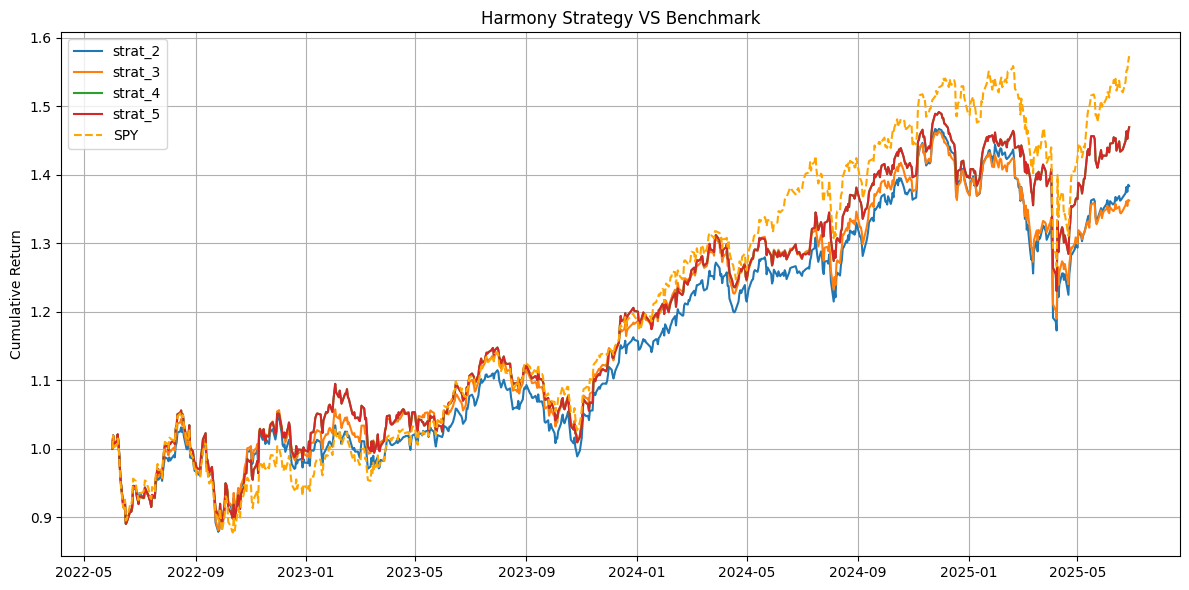

In [26]:
benchmark_cum = plot_with_benchmark([cr_strat_2, cr_strat_3, cr_strat_4, cr_strat_5],
                                    benchmark_df,
                                    start_date=start_date,
                                    end_date=end_date,
                                    title="Harmony Strategy VS Benchmark")

#### ii. Indicators VS Benchmark

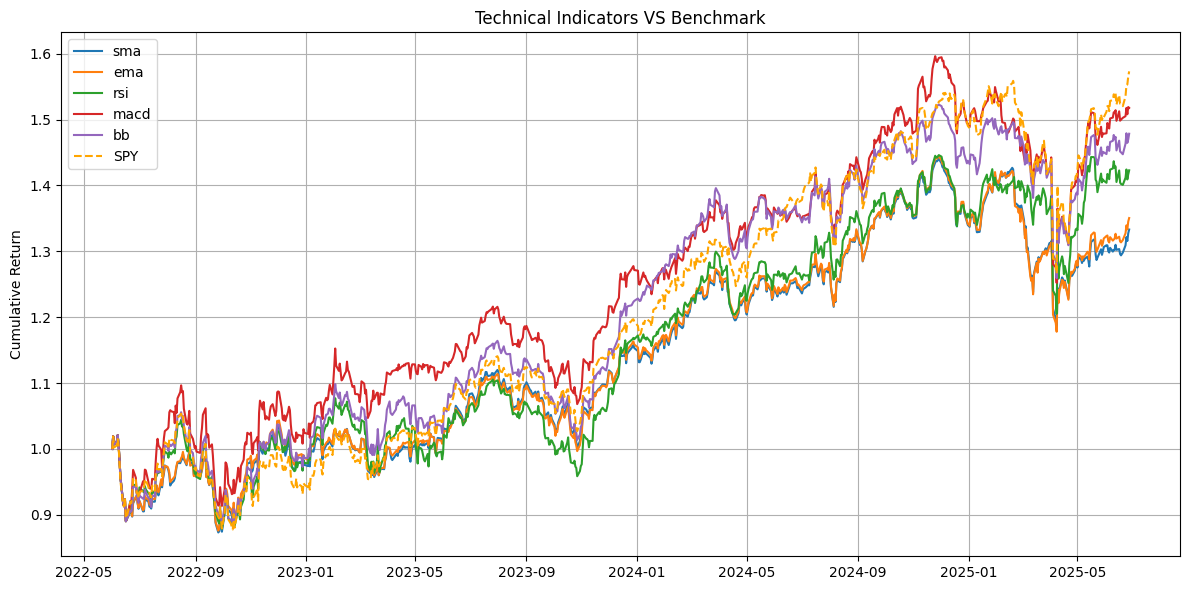

In [27]:
benchmark_cum = plot_with_benchmark([cr_sma, cr_ema, cr_rsi, cr_macd, cr_bb],
                                    benchmark_df,
                                    start_date=start_date,
                                    end_date=end_date,
                                    title="Technical Indicators VS Benchmark")